# Training a Face Mask Detection Classifier using the FastAi library


Masks play an important role in protecting the health of individuals
against respiratory diseases. Masks have become a necessity during the current pandemic situation since they are one of the few precautions available in the absence of immunization. 

This project aims to create a classier that predicts whether a person in an image is:
- (properly) wearing a mask,
- wearing a mask improperly, or 
- not wearing a mask at all. 

We will use the [fastai](https://github.com/fastai/fastai) deep learning library to create this classifier. This library provides the experimental tools to quickly and easily genereate state-of-the-art results in many deep learning domains.

First let's setup the necessary packages and configurations.

In [3]:
# ensures that any edits to libraries are reloaded automatically 
%reload_ext autoreload
%autoreload 2

# show charts and/or images in the notebook itself.
%matplotlib inline

# import all computer-vision related packages from fast-ai
from fastai.vision import *

# import the error-rate metic
from fastai.metrics import error_rate

# in order to access the necessary data - we have to mount the Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## The Data

To train the 'mask detection classifier', we are going to use the [Mask Dataset (Make ML)](https://makeml.app/datasets/mask). 

This dataset has images that fall into three classes:
- Images of people **with mask**,
- Images of people **without mask**,
- Images of people **wearing masks incorrectly**.

The labels of these images are stored as folder names in this particular dataset. Therefore, we have to extract the folder names when we import the data in order to train our classifier. We can use the fastai library's `ImageDataBunch.from_folder()` function to execute this step.

In [5]:
# path to the parent folder and train dataset folder
path = '/content/drive/My Drive/my_projects'
image_path = '/datasets/mask_data/train/'

np.random.seed(16) # to guarantee that the same validation set
bs = 32 # batch size to sample

data = ImageDataBunch.from_folder(path + image_path 
                                  , valid_pct=0.25
                                  , size=200
                                  , bs=bs
                                  , seed =  16
                                  ).normalize(imagenet_stats)

Before we move onto train the classifier, let's take a look at the data to understand what the problem is and how does the data look like.



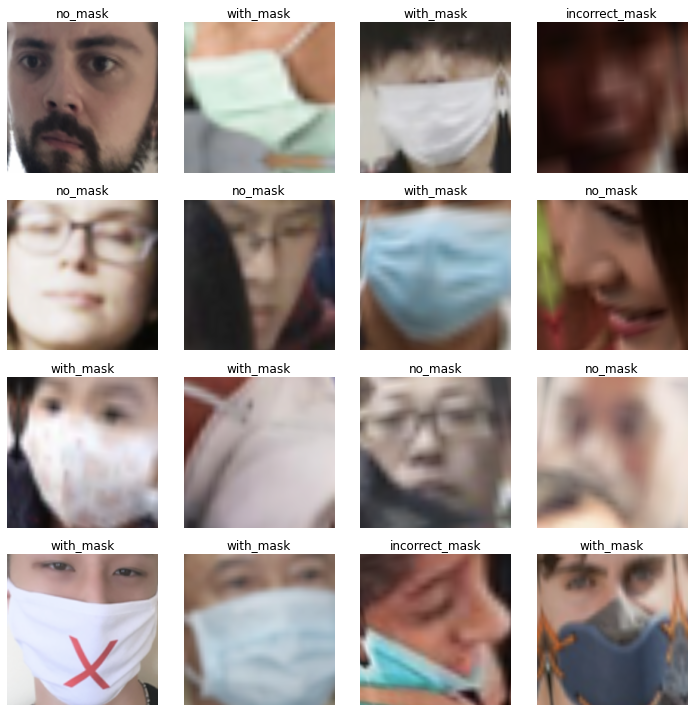

In [ ]:
data.show_batch(rows=4, figsize=(10,10))

In [ ]:
print(data.classes)
len(data.classes),data.c

['incorrect_mask', 'no_mask', 'with_mask']


(3, 3)

We can see that the images are grouped under three categories: `with_mask`, `no_mask` and `incorrect_mask`. The corresponding images contain face-images of people wearing masks as per the assigned category.

## Training a classifier using transfer-learning 

Instead of training a classifier from scratch, we use the technique of [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) to create our model. Transfer learning technique focuses on applying the knowledge gained when solving one problem to solve a different but a related problem. 

### Using the weights of `ResNet34`


We train our first classifier using the [`ResNet34`](https://pytorch.org/hub/pytorch_vision_resnet/) model architecture. 

Let's train our classifier with these pre-trained weights for 4 epochs.

In [ ]:
learnRes34 = cnn_learner(data, models.resnet34, metrics=error_rate)

learnRes34.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.962703,0.550357,0.153680,00:18
1,0.643265,0.429303,0.108225,00:18
2,0.464482,0.343920,0.101732,00:18
3,0.360837,0.293868,0.088745,00:18


In [ ]:
# save the trained classifer (model) weights
learnRes34.save(path + '/models/mask_detect_weights_resnet_34_stage_1')

#### Results

Looking at the training results, we see that after the 4th epoch, the error-rate of our classifier was ~9%. That means it can predict the correct category ~91% of the time.

Let's observe the predictions of the model to understand which categories that the classifier got most confused with another. This helps us to verify the performance of the model. 



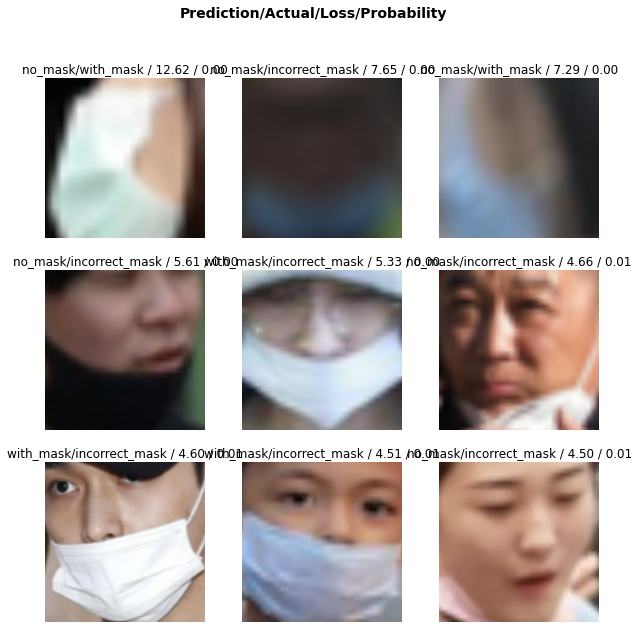

In [ ]:
interpRes34 = ClassificationInterpretation.from_learner(learnRes34)

interpRes34.plot_top_losses(9, figsize=(10,10))

The mistakes of the classifier were mostly among `incorrect_mask` vs others. This is reasonable because the `incorrect_mask` category lies between the other two classes. This step indicates that our classifier works as intended.

The below confusion matrix also confirms that the model makes the most mistakes when identifying the `incorrect mask` category.


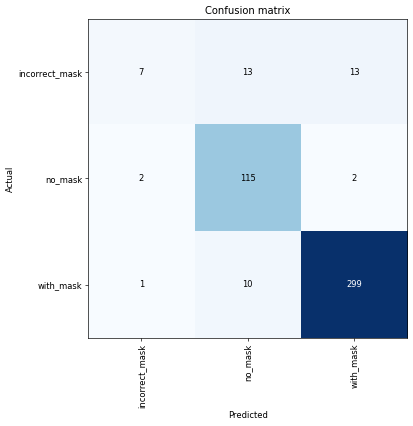

In [ ]:
interpRes34.plot_confusion_matrix(figsize=(7,7), dpi=60)

Below `most_confused()` function also supports the above conclusion.

In [ ]:
interpRes34.most_confused(min_val=10)

[('incorrect_mask', 'no_mask', 13),
 ('incorrect_mask', 'with_mask', 13),
 ('with_mask', 'no_mask', 10)]

### Using the weights of `ResNet50`


Let's use the more complex `ResNet50` architecture which has more layers than `ResNet34` to train a classifier and check if that can produce better predictions.

Since `ResNet50` has a high number of layers, it can extract more features. Therefore, let's use slightly larger images in our dataset.

In [ ]:
data_b = ImageDataBunch.from_folder(path + image_path 
                                  , valid_pct = 0.25
                                  , size = 300
                                  , bs = bs
                                  , seed =  16
                                  ).normalize(imagenet_stats)


learnRes50 = cnn_learner(data_b, models.resnet50, metrics=error_rate)

learnRes50.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.939615,0.561532,0.147186,00:47
1,0.622656,0.301379,0.086580,00:47
2,0.435782,0.261422,0.077922,00:47
3,0.316495,0.240176,0.080087,00:47


In [ ]:
# save the trained classifer (model) weights
learnRes50.save(path + '/models/mask_detect_weights_resnet_50_stage_1')

#### Results


Above results show us that the error-rate of the new classifier drops ~7%  after 3 epochs and increases to 8% in the 4th epoch of training. This shows signs of overfitting.

Overall, the classifier that we trained using `ResNet50` seems perform better than the classifier trained using `ResNet34` model.

We can perform the same analysis as above to identify the classes our classifier was most confused with.


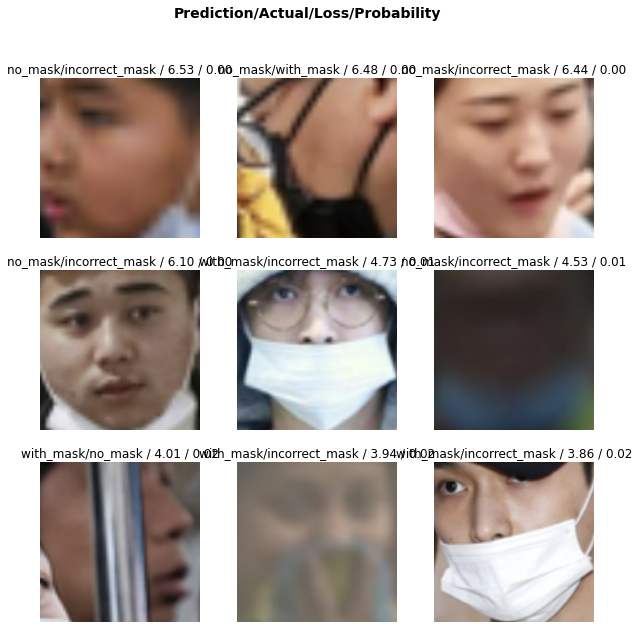

In [ ]:
interpRes50 = ClassificationInterpretation.from_learner(learnRes50)

interpRes50.plot_top_losses(9, figsize=(10,10))

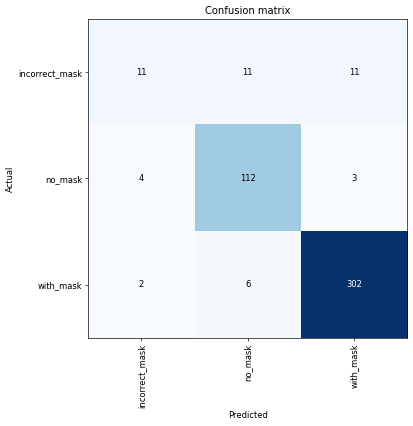

In [ ]:
interpRes50.plot_confusion_matrix(figsize=(7,7), dpi=60)

The new classifier has a slighly higher accuracy in identifying the `incorrect_mask` class than the previous classifier, whereas the `no_mask` class is identified with less accuracy.

## Unfreezing the pre-trained networks for fine-tuning

Instead of using the pre-trained weights as they are (i.e., keeping them *freezed*), now we are going to train all parameters of `ResNet34` and `ResNet50` models using our training data. We hope that by doing this, we would be able to train classifiers that have higher accuracy.


#### Unfreezing and fine-tuning the classifiers based on `ResNet34` and `ResNet50` 

In [ ]:
learnRes34_ii = cnn_learner(data, models.resnet34, metrics=error_rate)
learnRes34_ii.load(path + '/models/mask_detect_weights_resnet_34_stage_1'); 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


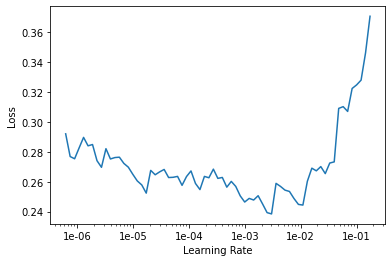

In [ ]:
# run learning-rate finder to manually pick learning rates for NN
learnRes34_ii.lr_find()
learnRes34_ii.recorder.plot()

In [ ]:
# unfreeze the weights
learnRes34_ii.unfreeze()

# pick learning rates using above graph
learnRes34_ii.fit_one_cycle(4, max_lr=slice(1/8000,1/400))

epoch,train_loss,valid_loss,error_rate,time
0,0.313930,1.136596,0.112554,00:19
1,0.307432,0.572424,0.088745,00:19
2,0.221283,0.118523,0.041126,00:19
3,0.165354,0.127502,0.036797,00:20


In [ ]:
# save the new model weights
learnRes34_ii.save(path + '/models/mask_detect_weights_resnet_34_stage_2')

Comparing above results with the previous classifier that we traind using `ResNet34` model weights, we can see that the new error rate is ~4% lower! The new classifier would predict the correct class ~96% of the time!!

Let's apply the same process on the classifier based on `ResNet50` model and compare the results.

In [ ]:
learnRes50_ii = cnn_learner(data_b, models.resnet50, metrics=error_rate)
learnRes50_ii.load(path + '/models/mask_detect_weights_resnet_50_stage_1'); # load previously trained model weights

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


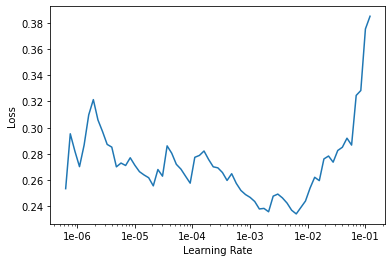

In [ ]:
# run learning-rate finder to manually pick learning rates for NN
learnRes50_ii.lr_find()
learnRes50_ii.recorder.plot()

In [ ]:
# unfreeze the weights
learnRes50_ii.unfreeze()

# pick learning rates using above graph
learnRes50_ii.fit_one_cycle(4, max_lr=slice(1/60000,1/600))

epoch,train_loss,valid_loss,error_rate,time
0,0.177162,0.655838,0.125541,01:01
1,0.288874,0.210695,0.075758,01:01
2,0.232796,0.158358,0.047619,01:01
3,0.170269,0.127457,0.034632,01:01


In [ ]:
# save the new model weights
learnRes50_ii.save(path + '/models/mask_detect_weights_resnet_50_stage_2')

The fine-tuned `learnRes50_ii` that we created using `ResNet50` network records an error rate ~3.4%. This is even slightly less than the error rate of the tuned `ResNet34` based model.

#### Results

As the final step, let's have a look at the confusion matrices of the fine-tuned models.

In [ ]:
interpRes34_ii = ClassificationInterpretation.from_learner(learnRes34_ii)
interpRes50_ii = ClassificationInterpretation.from_learner(learnRes50_ii)

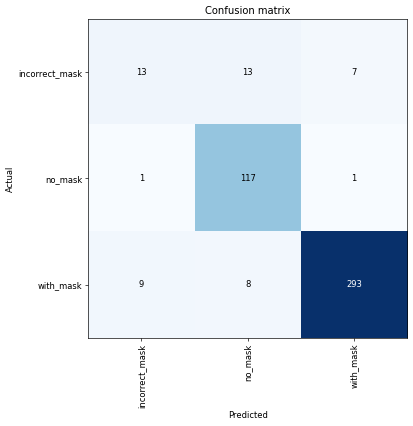

In [ ]:
interpRes34_ii.plot_confusion_matrix(figsize=(7,7), dpi=60)

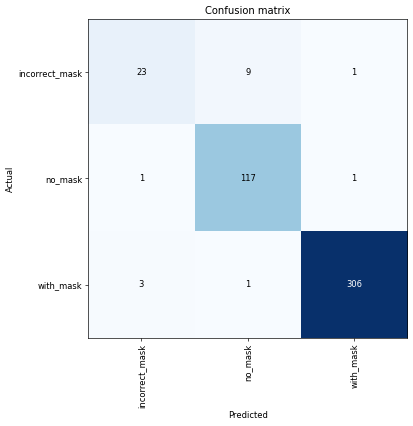

In [ ]:
interpRes50_ii.plot_confusion_matrix(figsize=(7,7), dpi=60)

As we can observe in the above results, the fine-tuned `ResNet50` based classifier accurately predicts all three classes better than `ResNet34` based classifier. Therefore, we can conclude that the `interpRes50_ii` classifier is more suitable to draw inferences about the proper use of face masks in image inputs.

## Data Augmentation to find improved model(s)

We showed that it is possible to train a state-of-the-art mask detecting classifier with transfer learning using pre-trained models. In this section, we explore how [**data augmentation**](https://en.wikipedia.org/wiki/Data_augmentation) techniques can be used to train an even better performing classifier.

Data augmentation is a technique that is used to increase the amount of data by adding slightly modified copies of already existing data. The fast-ai library offers various in-built data augmenting methods which can be applied on image data using the [`get_transforms()`](https://fastai1.fast.ai/vision.transform.html#get_transforms) function.

Before we select the transformations to apply on the data, it is important to first have a look at the data so that we can understand which data augmentation methods make sense.

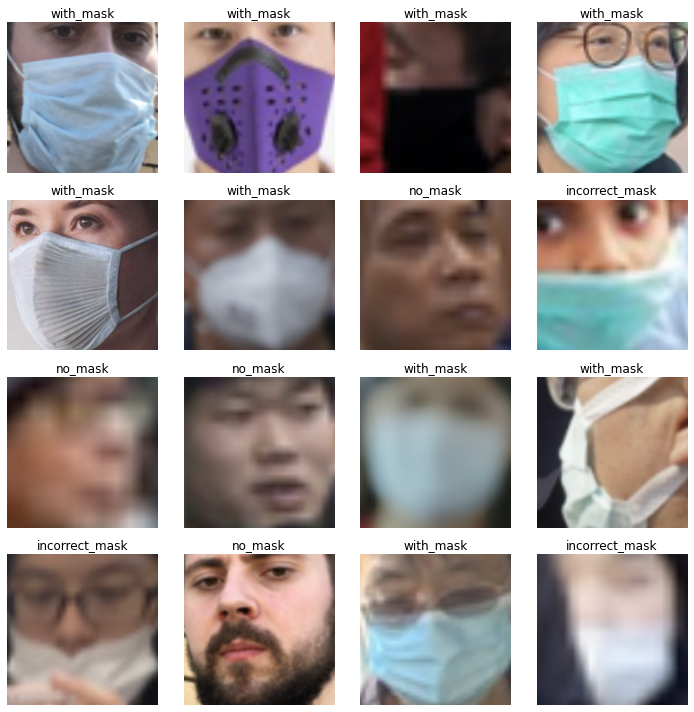

In [5]:
np.random.seed(16) # to guarantee that the same validation set
bs = 32 # batch size to sample

data_no_aug = ImageDataBunch.from_folder(path + image_path 
                                  , valid_pct=0.25
                                  , size=200
                                  , bs=bs
                                  , seed =  16
                                  ).normalize(imagenet_stats)

data_no_aug.show_batch(rows=4, figsize=(10,10))

We apply below transformations on input images to create an extended training dataset.

In [12]:
additional_aug = [*zoom_crop(scale=(0.8,1.1), do_rand=True) # Randomly zoom and/or crop
               , pad(mode='reflection')                     # Pad the image by adding padding pixel on each side of the picture 
               , brightness(change = (.3,.7))               # Apply change in brightness
               , contrast(scale = (.7,1.7))                 # Apply change in contrast
               , squish(scale = .9)]                        # Squish image by scale                 
                                    

tfms = get_transforms(do_flip = True, flip_vert = False # apply random horizontal flips with probability 0.5
                      , max_rotate = 20                 # apply random rotation with probability p_affine
                      , max_zoom = 0.5                  # apply max_zoom with probability p_affine (lower max set because of blury images)
                      , max_warp = 0.2                  # random symmetric warp applied with probability p_affine
                      , p_affine = 1.                   # the probability that each affine transform and symmetric warp is applied
                      , xtra_tfms = additional_aug
                      )

data_aug = ImageDataBunch.from_folder(path + image_path 
                                  , valid_pct = 0.25
                                  , bs=bs
                                  , size=250
                                  , seed =  16
                                  , ds_tfms = tfms 
                                  ).normalize(imagenet_stats)

We have applied a bunch of transformations on image data that we thought would help to better recognize the three classes.

Now let's look at a sample of images after applying these transformations.

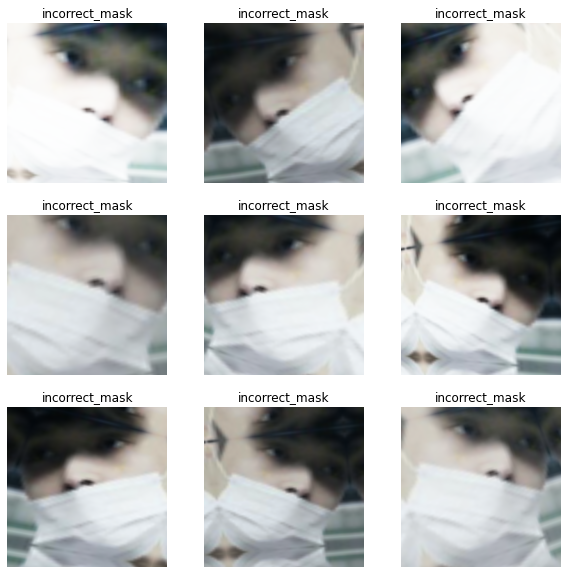

In [81]:
def _plot(i,j,ax):
    x,y = data_aug.train_ds[444]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(10,10))

## Training a classifier using Augmented Data

Since we saw that the `ResNet50` network is able to produce better results at the previous step, we use it to train our classifier on the extended dataset.

In [97]:
learnRes50_iii = cnn_learner(data_aug
                             , models.resnet50
                             , metrics=error_rate
                             #, bn_final = True    # adding a BatchNorm layer for the output - this was found to be helpful
                             )      

learnRes50_iii.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.022945,0.619565,0.162338,00:28
1,0.639181,0.372607,0.123377,00:28
2,0.460901,0.300064,0.086580,00:28
3,0.364510,0.278763,0.088745,00:28


With default configurations, the new classifier model is able to correctly predict the classes ~92% of the time.

Now lets unfreeze the network and try to fine-tune the learning rate!

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


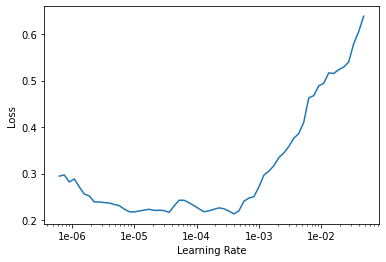

In [98]:
learnRes50_iii.unfreeze()
learnRes50_iii.lr_find()
learnRes50_iii.recorder.plot()

In [113]:
learnRes50_iii.fit_one_cycle(2
                             , max_lr=slice(1/800000,1/8000)      # employ the `discriminative layer training' technique
                             , pct_start = 0.1                    # percentage of overall iterations where the LR is increasing
                             )

epoch,train_loss,valid_loss,error_rate,time
0,0.024349,0.127863,0.032468,00:29
1,0.022322,0.128980,0.032468,00:29


In [174]:
# save the new model weights
learnRes50_iii.save(path + '/models/mask_detect_weights_resnet_50_stage_3')

# the loss function used in our classifier (cnn_learner)
learnRes50_iii.loss_func   

FlattenedLoss of CrossEntropyLoss()

After experimenting with different values for the `max_lr` parameter, it was possible to find a new classifier with an accuracy of ~97%! The use of augmented data helped to increase the accuracy by 0.2% compared with the performance of the `learnRes50_ii` model we trained before. Even though the incremental improvement is not significant, it provides evidence to show that data augmentation does help to improve model performance futher. 

Now with this classifier at hand, let's have a closer look at our model and try to understand what is happening inside it.

## Convolution Neural Networks

Our classifier was created using the `ResNet50` network and it has a [Convolution Neural Networks (CNN)](https://en.wikipedia.org/wiki/Convolutional_neural_network) backbone. 

In this section, we look at what part(s) of an input image that our classifier focuses on when it tries to decide what that input image is.

Let's first load a random image for our experiment.

'with_mask'

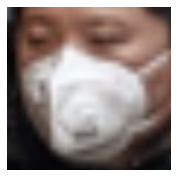

In [165]:
idx = 4
x,y = data_aug.valid_ds[idx]
x.show()
data_aug.valid_ds.y[idx].obj

Now, we look at the last `Conv2d` convolution layer  of our classifier (model). This layer has a dimension of `(2048 x 8 x 8)`. 

By taking the average across all 2048 channels for each point on the 8 x 8 grid of this layer, we can idenfity how activated each grid-point *(on the resulting 8 x 8 grid)* is when it comes to figuring out that the person in the image is "wearing a mask".

We can represent this activation level of each grid-point by creating a "heatmap" as below.

torch.Size([2048, 8, 8])
torch.Size([8, 8])


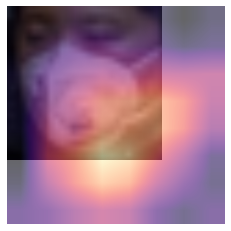

In [166]:
m_eval = learnRes50_iii.model.eval()     # set the model to evaluation mode

xb,_ = data_aug.one_item(x)              # create a mini-batch with one item
xb_im = Image(data_aug.denorm(xb)[0])    # convert input image tensor to a format suitable for display by MatPlotlib (reverse the normalization)
xb = xb.cuda()                           # set the mini-batch to GPU

from fastai.callbacks.hooks import *

def hooked_backward(cat=y):
    with hook_output(m_eval[0]) as hook_a:                # create a hook to the output of the convolutional part of the model: `m_eval[0]' (coming from ResNet50)
        with hook_output(m_eval[0], grad=True) as hook_g:
            preds = m_eval(xb)                            # execute the forward pass by sending the mini-batch (of size 1)  
            preds[0,int(cat)].backward()
    return hook_a,hook_g

hook_a,hook_g = hooked_backward()

activations  = hook_a.stored[0].cpu()          # activations of the last 2048x8x8 layer
print(activations.shape)

avg_activations = activations.mean(0)          # compute averages across 0-dimension (resulting 8x8 grid having means across 2048 channels)       
print(avg_activations.shape)

def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6
              , extent=(0,352,352,0)
              , interpolation='bilinear'
              , cmap='magma');

show_heatmap(avg_activations)                  # plot the (average) activations heatmap on the input image

Similarly, we can also use the [**Grad-CAM**](https://arxiv.org/abs/1610.02391) method to produce the same result. This method uses the gradients of a target class, flowing into the final convolutional layer to produce a coarse localization map that highlights the important regions in the image for predicting the target class.

In [167]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape, grad_chan.shape

(torch.Size([2048, 8, 8]), torch.Size([2048]))

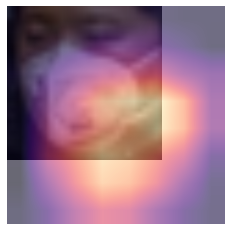

In [168]:
mult = (activations*grad_chan[...,None,None]).mean(0)
show_heatmap(mult)

As we can see, the area of the image that contains the mask has the most activations when our model assigns the image into the `with_mask` class.

## [Augmented data + larger images] $\rightarrow$ ResNet50 = Better Results ?

Since we could produce better results using larger images with `ResNet50` before, as the final step, let's give that a try!

In [6]:
additional_aug = [*zoom_crop(scale=(0.8,1.1), do_rand=True) # Randomly zoom and/or crop
               , pad(mode='reflection')                     # Pad the image by adding padding pixel on each side of the picture 
               , brightness(change = (.3,.7))               # Apply change in brightness
               , contrast(scale = (.7,1.7))                 # Apply change in contrast
               , squish(scale = .9)]                        # Squish image by scale                 
                                    

tfms = get_transforms(do_flip = True, flip_vert = False # apply random horizontal flips with probability 0.5
                      , max_rotate = 20                 # apply random rotation with probability p_affine
                      , max_zoom = 1.                   # apply max_zoom with probability p_affine (lower max set because of blury images)
                      , max_warp = 0.2                  # random symmetric warp applied with probability p_affine
                      , p_affine = 1.                   # the probability that each affine transform and symmetric warp is applied
                      , xtra_tfms = additional_aug
                      )

data_aug2 = ImageDataBunch.from_folder(path + image_path 
                                  , valid_pct = 0.25
                                  , bs = bs
                                  , size = 300            # LARGER IMAGES
                                  , seed =  16
                                  , ds_tfms = tfms 
                                  ).normalize(imagenet_stats)

In [8]:
learnRes50_iv = cnn_learner(data_aug2
                             , models.resnet50
                             , metrics=error_rate
                             #, bn_final = True    # adding a BatchNorm layer for the output - this was found to be helpful
                             )      

learnRes50_iv.fit_one_cycle(4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.047189,0.541329,0.162338,04:18
1,0.609407,0.469212,0.123377,00:38
2,0.521088,0.307162,0.095238,00:37
3,0.392513,0.340726,0.099567,00:36


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


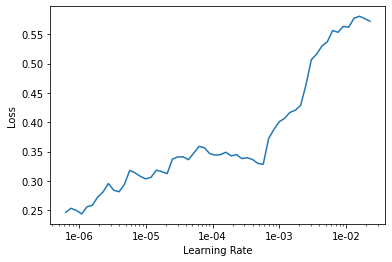

In [9]:
learnRes50_iv.unfreeze()

learnRes50_iv.lr_find()
learnRes50_iv.recorder.plot()

In [10]:
learnRes50_iv.fit_one_cycle(4
                             , max_lr=slice(1/10000,1/3000)   # employ the `discriminative layer training' technique
                             , pct_start = 0.2                # percentage of overall iterations where the LR is increasing
                             )

epoch,train_loss,valid_loss,error_rate,time
0,0.331156,0.462360,0.121212,00:38
1,0.293475,0.154624,0.043290,00:39
2,0.207644,0.146361,0.047619,00:38
3,0.156585,0.133249,0.041126,00:38


Using larger images with augmented data does not seem to significantly improve the classifier's performance. This could be because the augmented data (e.g., zoomed images) could have already made the previous classifier `learnRes50_iv` capture the features that larger images has to offer.

## Deeper look at *'Kernel(s)'*


The [convolution matrices AKA kernels](https://en.wikipedia.org/wiki/Kernel_(image_processing)#:~:text=In%20image%20processing%2C%20a%20kernel,a%20kernel%20and%20an%20image.) are the primary units of a CNN. Therefore, it is important to be familiar with them so that we can understand what is happening in the background when we use a convolution layer in a neural network (NN).

The easiest way to understand how kernels work is to observe how different kernels affect images. Let's consider the following five kernels and see what sort of an effect they have on an image.

'with_mask'

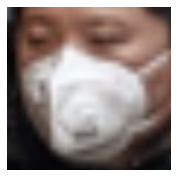

In [15]:
# sample image
x.show()
data_aug.valid_ds.y[idx].obj

In [92]:
# define custom kernel matrices
ker1 = tensor([[0. , 1. , 0.],
               [1. , 4. , 1.],
               [0  , 1. , 0.]]).expand(1,3,3,3)/6 # NN only accepts tensors with rank 4

ker2 = tensor([[-4. , -1. , -4.],
               [-1. ,  1. , -1.],
               [-4  , -1. , -4.]]).expand(1,3,3,3)/6 # NN only accepts tensors with rank 4

ker3 = tensor([[1. , 1. , 1. , 1. , 1.],
               [1. , 1. , 1. , 1. , 1.],
               [1  , 1. , 1. , 1. , 1.],
               [1  , 1. , 1. , 1. , 1.],
               [1  , 1. , 1. , 1. , 1.]]).expand(1,3,5,5)/6 # NN only accepts tensors with rank 4

ker4 = tensor([[1. , 0. , -1.],
               [1. , 0. , -1.],
               [1  , 0. , -1.]]).expand(1,3,3,3)/6 # NN only accepts tensors with rank 4

ker5 = tensor([[1. , 1. ,  1.],
               [0. , 0. ,  0.],
               [-1  , -1. , -1.]]).expand(1,3,3,3)/6 # NN only accepts tensors with rank 4

In [68]:
# reshape the sample image vector
img_sample = x.data

print(f'sample image shape: {img_sample.data.shape}')           # shape of the sample image

print(f'reshaped image sample shape: {img_sample[None].shape}') # convert the sample image to rank 4

sample image shape: torch.Size([3, 250, 250])
reshaped image sample shape: torch.Size([1, 3, 250, 250])


In [93]:
# apply custom kernels to sample image
out1 = F.conv2d(img_sample[None],ker1)
out2 = F.conv2d(img_sample[None],ker2)
out3 = F.conv2d(img_sample[None],ker3)
out4 = F.conv2d(img_sample[None],ker4)
out5 = F.conv2d(img_sample[None],ker5)

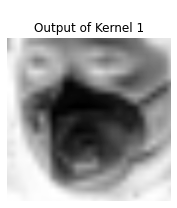

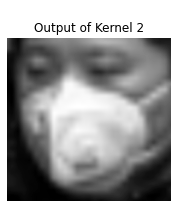

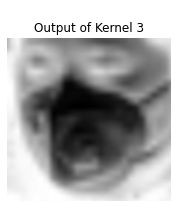

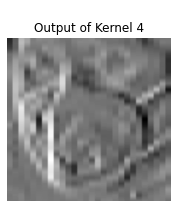

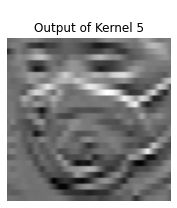

In [100]:
img_li = [out1[0],out2[0],out3[0],out4[0],out5[0]]

for i in range(5):
  a = show_image(img_li[i], figsize=(3,3))
  a.set_title(f'\nOutput of Kernel {i+1}')

We can see that the kernels extract very specifc (visual) information from the input image according to the weights/values of their respective convolution matrices.

Let's also extract the first kernel used in our classifier (derived from `ResNet50`) and see what sort of an effect it has on this image.

In [101]:
learn = cnn_learner(data_aug , models.resnet50 , metrics=error_rate)

In [104]:
learn.model.parameters

<bound method Module.parameters of Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequen

The first Conv2d layer is `Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)`. It has 64 kernels of size 7x7 which accepts images with 3 channels. The stride is 2 for these kernels, therefore, the input image size would be halved by this layer. Also, it applies a padding of 3 [`=int(7/2)`] to avoid the image size getting shrinked further.

Let's extract this convolution layer and apply few of its kernels to a sample image.


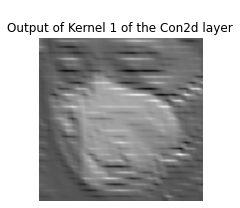

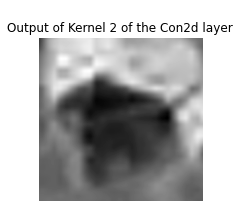

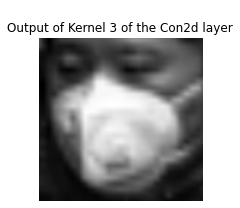

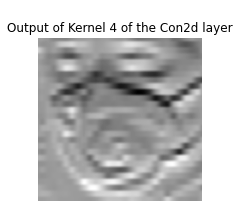

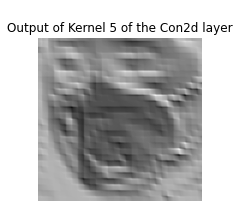

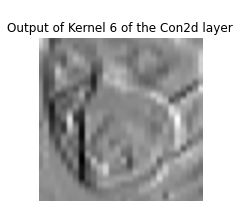

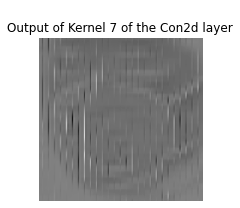

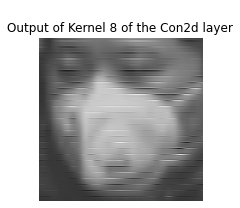

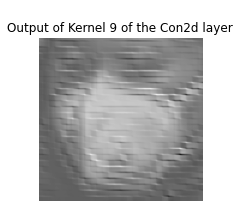

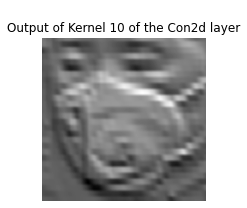

In [149]:
selected_kernels = learn.model[0][0].weight[:10]

i=0
for kernel in selected_kernels:

  img = F.conv2d(img_sample[None].cuda(),kernel.expand(1,3,7,7))[0]
  a = show_image(img, figsize=(3,3))
  a.set_title(f'\nOutput of Kernel {i+1} of the Con2d layer')
  i += 1


As we can see, each kernel extracts different features of the input image. This allows the first convolution layer to dissect many granular low-level features from input images so that these low-level features can be aggregated to generate more complex features at latter layers. 